# Logistic Regression

## What we will accomplish

In this notebook we will:
- Learn the logistic regression algorithm,
- Show how you can interpret logistic regression output,
- Talk about classification cutoffs and
- Think about predicting probabilities instead of hard classification.

## Explaining the Model

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

We will explain using a toy example.  A standard apple tree which is only $1$ foot tall is unlikely to bear fruit this year.  However an apple tree which is $20$ feet tall is very likely to be of bearing age.  We might expect an increasing relationship between the height of the tree and the probability that the tree is capable of bearing fruit.



In [2]:
height_vs_bearing = pd.read_csv('lecture_8_assets/height_vs_bearing.csv', index_col=0)

In [3]:
height_vs_bearing

,height,bearing
0,11.325206,0.0
1,12.939280,1.0
2,9.767215,1.0
3,7.638947,0.0
4,8.997293,0.0
...,...,...
95,12.316341,1.0
96,8.523462,0.0
97,7.432771,0.0
98,7.105060,0.0


We can see that we have measured the height of 100 apple trees, and recorded whether or not the tree is currently bearing apples.

Here is a graph of the data:

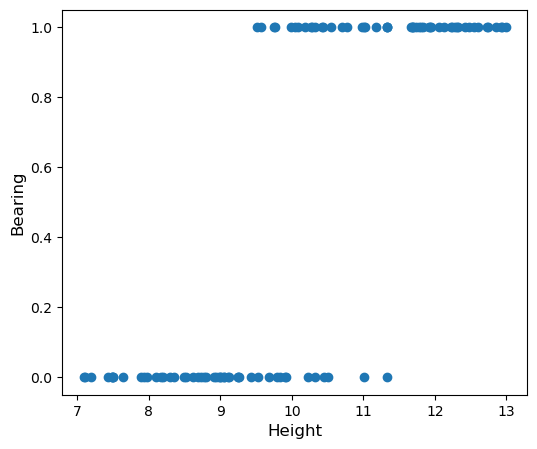

In [4]:
plt.figure(figsize=(6,5))

plt.scatter(height_vs_bearing['height'], height_vs_bearing['bearing'])

plt.xlabel("Height", fontsize=12)
plt.ylabel("Bearing", fontsize=12)
plt.show()

As we can see, when the tree is shorter than 9 feet tall it is very rare for it to bear apples.  When it is taller than 11.5 feet tall it is almost surely going to bear apples.  In between we have a murkier situation.  One thing we could do to try to get a better understanding of this relationship is try and see how the probability of bearing varies as a function of height.  We can estimate the probability $P(\textrm{bearing} = 1 | x )$ by looking at the empirical probability of bearing in a small neighborhood of $x$, say $$P(\textrm{bearing} = 1 | \textrm{height} = x ) \approx \frac{\textrm{\# samples bearing}}{\textrm{\# samples in }[x-0.5,x+0.5]}$$  

Let's take a look at that graph.  I have highlighted the point with $\textrm{height} = 9.5$ green.  In the interval $[9,10]$ there are $20$ samples of which $5$ are bearing, for an estimated probability of $\frac{5}{20} = 0.25$

![Approximate probabilities](lecture_8_assets/approx-probs.png)

We would like to model the probability as a funtion of height directly.  Our model might look something like this:

![approximate probabilities with logistic regression curve](lecture_8_assets/approx-probs-with-curve.png)

In logistic regression we will model the probability $P(\textrm{bearing} = 1| \textrm{height} = x)$ using a function of the form $p(x) = \sigma(mx+b)$ where $\sigma$ is the *sigmoid function* defined by

$$
\sigma(t) = \frac{1}{1+e^{-t}}
$$

We can interpret this as follows

$$
\begin{align*}
&p(x) = \frac{1}{1+e^{-(mx+b)}}\\
&\frac{1}{p(x)} = 1 + e^{-(mx+b)}\\
&\frac{1 - p(x)}{p(x)} = e^{-(mx+b)}\\
&\frac{p(x)}{1-p(x)} = e^{mx+b}\\
&\log\left(\frac{p(x)}{1-p(x)}\right) = mx+b
\end{align*}
$$

The quantity $\frac{p(x)}{1-p(x)}$ is the [odds](https://en.wikipedia.org/wiki/Odds) in favor of bearing.

So by modeling our probability using the parameteric family $p(x) = \sigma(mx+b)$ we are making the assumption that the log-odds in favor of bearing is approximately linear in the height.  In other words, we are assuming that each additional foot of height increases the log-odds in favor of bearing by a fixed amount ($m$).  Phrased in terms of the odds, we are saying that each additional foot of height multiplies the odds in favor of bearing by $e^m$.

This assumption may or may not be reasonable, just like fitting a linear regression may or may not be reasonable.  In this case our exploratory plot makes it look like a reasonable model.

## Generalizing to multiple features

We have $n$ samples which each have $p$ continuous variables $x_1, x_2, x_3, ..., x_p$ and one binary variable $y$ (which is either $0$ or $1$ for each sample).  We want to model the probability that $y = 1$ as a function of these variables using a model with parameters $\beta = (\beta_0, \beta_1, \beta_2, \beta_3, ..., \beta_p)$ where $\beta \in \mathbb{R}^{p+1}$.  In other words, we want to model the probability as some function $p_\beta: \mathbb{R}^p \to [0,1]$ which depends on these parameters.  

The logistic regression model is that

$$
p(y = 1 | \vec{x}) = \sigma(\vec{x} \cdot \vec{\beta})
$$

here we are adopting the convention of augmenting $\vec{x}$ with an initial $1$ to capture the intercept term.

The interpretation of the fit parameters $\hat{\beta}$ is the same:  if $x_j$ increases by one unit, the log-odds that the $y=1$ increases by $\hat{\beta}_j$.

## The Binary Cross Entropy Loss Function

We will increase the generality a bit and think about an appropriate loss function for **any** conditional probability with binary outcomes.

$$P(y = 1 | \vec{x} ; \vec{\beta}) = p_{\vec{\beta}}(\vec{x})$$

The question we have is how to select the parameters $\beta$ so as to maximize the likelihood that the data in our sample was generated by the model. 

Fix the parameters $\beta$.  For a single observation $(\vec{x},y)$ the model predicts this observation will occur with a probability of

$$
\begin{cases}
p_\beta(\vec{x}) \textrm{ if $y = 1$}\\
1 - p_\beta(\vec{x}) \textrm{ if $y = 0$}
\end{cases}
$$

We can write this more compactly as the single expression 

$$
y p_\beta(\vec{x}) + (1-y)(1 - p_\beta(\vec{x}))
$$

So our model predicts that the probability that our sample of $N$ observations occurs is 

$$
L(\beta) = \prod_{i=1}^{n} \left(y_i p_\beta(\vec{x_i}) + (1-y_i)(1 - p_\beta(\vec{x_i}))\right)
$$

Our goal is to find the value of $\beta$ which maximizes this quantity.

We are now going to take the logarithm of the likelihood function:

$$
\log(L(\beta)) = \sum_{i = 1}^{n} y_i \log (p_\beta(\vec{x_1}))  + (1 - y_i)\log(1 - p_\beta(\vec{x_i}))
$$

Why did we take the logarithm?  Several reasons:

* The logarithm is monotonically increasing, so the same $\beta$ maximizes both $L$ and $\log L$.
* The values of $L$ are probably quite small.  We are multiplying together lots of numbers which are between $0$ and $1$.  The result will be a tiny positive number.  Using a logarithmic transformation is a nice way to put these numbers on a more reasonable scale.
* We will eventually want to differentiate to find a maximum value.  The derivative of the likelihood uses the product rule, which would involve a product over all observations.  This is not very parallelizable.  The derivative of the log-likelihood only uses the sum rule, which results in a parallelizable derivative computation.

The log-likelihood is a negative number which we are trying to maximize.  By convention we will instead minimize the negative log-likelihood:

$$
 \ell(\beta) = - \log(L(\beta)) = - \sum_{i = 1}^{n} y_i \log (p_\beta(\vec{x_1}))  + (1 - y_i)\log(1 - p_\beta(\vec{x_i}))
$$

where I am using $\ell$ to stand for "loss".

This expression is called the [binary cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the model $p_\beta$ and the empirical probability from our observations $(\vec{x_i}, y_i)$.

You can do the calculus (or check the math hour notebook for a derivation) to see that in the particular case of Logistic Regression, where we use $p_{\vec{\beta}}(\vec{x}) = \sigma(\vec{x} \cdot \vec{\beta})$, we have

$$
\nabla \ell \big|_{\vec{\beta}} =  X^\top (\sigma(X\vec{\beta}) - \vec{y})
$$

where, as usual, we are recording our observations in a design matrix $X$ which has been augmented by an initial column of ones.

To minimize the loss function we need to find where the gradient vanishes.  Unfortunately, we cannot solve this analytically.  We will instead resort to numerical approximation.  

We first show a custom implementation using gradient descent and then show you how to use the `sklearn` model.

In [5]:
# I got this numerically stable implementation from Tim Vieira's blog post here
# https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
def sigmoid_func(x):
    '''Numerically stable sigmoid function.'''
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = np.exp(x)
        return z / (1 + z)

sigmoid = np.vectorize(sigmoid_func)

class CustomLogisticRegression():
    def __init__(self):
        self.beta = None

    def fit(self, X, y, learning_rate=0.1, tolerance=0.00001):
        '''Fits beta using gradient descent'''
        self.beta = np.random.randn(X.shape[1]+1)
        X = np.hstack([np.ones((X.shape[0],1)), X]) # adding column of ones to X
        Xt = X.transpose()
        grad = (1/X.shape[0])*np.dot(Xt, sigmoid(np.dot(X, self.beta) - y)) # formula for gradient of the binary cross entropy
        while np.linalg.norm(grad)>tolerance:
            self.beta -= learning_rate*grad # update beta
            grad = (1/X.shape[0])*np.dot(Xt, sigmoid(np.dot(X, self.beta)) - y) # update gradient

    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0],1)), X])
        return sigmoid(np.dot(X, self.beta))
        
    def predict(self, X, threshold = 0.5):
        return 1*(self.predict_proba(X) > threshold)

In [6]:
# This takes about 10 seconds on my computer
X = height_vs_bearing[['height']].values
y = height_vs_bearing['bearing'].values
my_log_reg = CustomLogisticRegression()
my_log_reg.fit(X,y)

### Using sklearn for Logistic Regression

In contrast to our gradient descent function, scikit-learn fits the model almost instantly!  They are using more sophisticated numerical analysis.  

See [the Broyden–Fletcher–Goldfarb–Shanno algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) for more details.

Also note that the `sklearn` includes l2 regularization by default.  If we want it to be unregularized we have to pass the option `penalty = None`.

In [7]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty=None)

## fit the model
log_reg.fit(X,y)

print(f'Our gradient descent function obtains the fit m = {my_log_reg.beta[1]} and b = {my_log_reg.beta[0]}')
print(f'sklearn obtains the fit m = {log_reg.coef_[0][0]} and b = { log_reg.intercept_[0]}')
print('These are pretty close!')

Our gradient descent function obtains the fit m = 2.3341682607615026 and b = -23.533334971994364
sklearn obtains the fit m = 2.3365872747509924 and b = -23.557743891760303
These are pretty close!


In [8]:
# demonstrate .coef_, .intercept_, .predict_proba, and .predict
print(log_reg.coef_)
print(log_reg.intercept_)
print(np.round(log_reg.predict_proba([[1],[10.5],[15]]),2))
print(np.round(log_reg.predict([[1],[10.5],[15]]), 2))

[[2.33658727]]
[-23.55774389]
[[1.   0.  ]
 [0.27 0.73]
 [0.   1.  ]]
[0. 1. 1.]


Let's see how the fit generated by sklearn looks.  You can check that the fit we obtained using gradient descent is indistinguishable to the human eye by uncommenting a line in the code below:

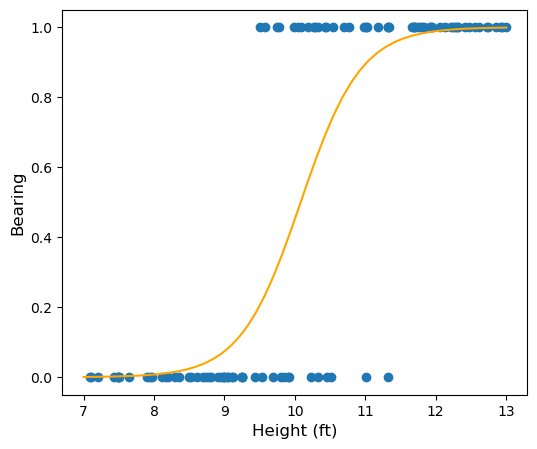

In [9]:
plt.figure(figsize=(6,5))

plt.scatter(X, y)

plt.plot(np.linspace(7,13), log_reg.predict_proba(np.linspace(7,13).reshape(-1,1))[:,1], color = 'orange')
#plt.plot(np.linspace(7,13), my_log_reg.predict_proba(np.linspace(7,13).reshape(-1,1)), c = 'k')

plt.xlabel("Height (ft)", fontsize=12)
plt.ylabel("Bearing", fontsize=12)
plt.show()

### From probabilities to classifications

We generate classifications from these predicted probabilities by choosing a *threshold*. 

For instance if $p(\vec{x})$ exceeds the threshold of $0.5$ we classify the instance as $1$, otherwise we say it is a $0$.  This is the most common threshold and is the default threshold used by `sklearn` to convert `.predict_proba` values into `.predict` classifications.

In [10]:
## set the cutoff
cutoff = .7

## store the predicted probabilities
y_prob = log_reg.predict_proba(X)[:,1]

## assign the value based on the cutoff
y_pred = 1*(y_prob >= .7)

## print the accuracy
## input the accuracy after "is",
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_pred == y)/len(y))

The training accuracy for a cutoff of 0.7 is 0.83


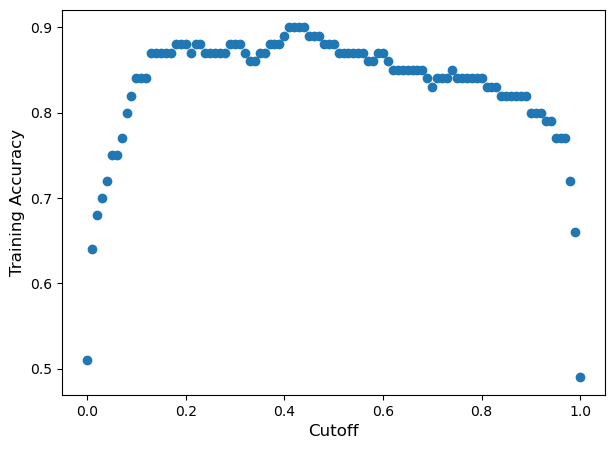

In [11]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_pred == y)/len(y))

plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

You should think carefully about how you select your decision boundary for classification.

For example consider the following two extremely different scenarios:

1. You use your classifier to decide which of two advertisements, which both market the same product, to show to a user on your website.
2. You use your classifier to decide whether or not to give a patient an additional diagnostic test for cancer.

In case 1 it might be reasonable to use a decision boundary of $0.5$.

In case 2 it would be an extremely *bad* idea to only give a follow up test if you predict cancer with greater than 50% probability.  You probably want to set the threshold much lower, and your selection of the boundary should carefully weigh the costs and benefits of false positives, false negatives, true positives, and true negatives.

## Linear decision boundaries

If we have $p$ features then our fit logistic regression model will be of the form

$$
P(y = 1 | \vec{x}) = \frac{1}{1 + e^{-(\beta_0 + \beta \cdot \vec{x})}}
$$

where I have temporarily changed conventions about $\vec{x}$ including an initial $1$.

If we set a decision boundary of $c$, then this boundary is

$$
\begin{align*}
\frac{1}{1 + e^{-(\beta_0 + \beta \cdot \vec{x})}} &= c\\
1 + e^{-\beta_0 + \beta \cdot \vec{x}} &= c^{-1}\\
e^{-\beta_0 + \beta \cdot \vec{x}} &= \frac{1-c}{c}\\
\beta_0 + \beta \cdot \vec{x} &= \log(\frac{c}{1-c})\\
\beta \cdot \vec{x} &= -\beta_0 + \log(\frac{c}{1-c})
\end{align*}
$$

This is a hyperplane in $\mathbb{R}^p$.  Note that adjusting $c$ gives you a family of parallel hyperplanes.

To illustrate this, I generate two classes with multivariate normally distributed features (but different means) and plot the decision boundary using $c = 0.5$

In [12]:
X0 = np.random.multivariate_normal([2,3], [[1,0],[0,1]], 100)
X1 = np.random.multivariate_normal([4,1], [[2,1],[1,2]], 100)
X = np.concatenate([X0,X1])
y = np.concatenate([np.zeros(100),np.ones(100)])

model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

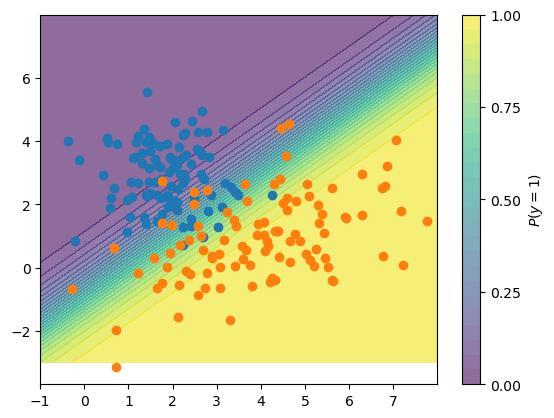

In [13]:
xx, yy = np.mgrid[-1:8:.01, -3:8:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

contour = plt.contourf(xx, yy, probs, 25, alpha = 0.6,
                      vmin=0, vmax=1)
                      
ax_c = plt.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

plt.scatter(X0[:,0],X0[:,1])
plt.scatter(X1[:,0],X1[:,1])

plt.show()

## Why use the sigmoid function?

It is very natural to ask why we use the sigmoid function instead of some other "S"-shaped curve.  There are a few reasons:

*  There is a very nice theory of "generlized linear models".  In brief:
    * We assume that the distribution $P(y | \vec{x})$ has a particular form which fits into an "exponential family" of distributions (in our case the Bernoulli distributions).
    * We specify a "link function" $g$ with $g(\mathbb{E}(y | \vec{x})) = \vec{x} \cdot \vec{\beta}$ (i.e. the link of the expected value is a linear function of the predictors).
    * In this setup we have a "canonical link function" (a bit technical to define).  For the Bernoulli family of distributions, $g(p) = \log(\frac{p}{1-p})$ is the canonical link function, and $g^{-1} = \sigma$.
        * The canonical link makes the calculus come out really nicely.  We saw in math hour that the gradient and hessian for logistic regression are extremely simple:  this generalizes to all generalized linear models.
* As we have already noted, the parameters are easily interpretable.

You *could* use other link functions.  A popular choice is the inverse of the cdf of the normal distribution $\Phi^{-1}$ which gives us "probit regression": we assume $\mathbb{E}(y | \vec{x}) = \Phi(\vec{x} \cdot \vec{\beta}$).
* This can be interpretted as assuming that our data generating process is that $y = 1$ when $\vec{x} \cdot \vec{\beta} + \epsilon > 0$ and $\epsilon \sim \mathcal{N}(0,1)$.
* $\Phi$ and $\sigma$ are good approximations of each other, so the results are often quite similar.
* Probit regression *is* preferable sometimes, such as when we want to avoid an assumption of [independence of irrelevant alternatives](https://en.wikipedia.org/wiki/Independence_of_irrelevant_alternatives).
* The interpretation of the model parameters is harder.
* The calculus of fitting the model is a lot harder (no nice closed form formulas).

### Algorithm Assumptions

While we were explaining the concept of logistic regression, we did not mention any of the assumptions of the algorithm. Let's talk about that here before we move on to real data.

- The log odds depend linearly on the regressors.
- The regressors are measured without error.
- The observations are independent.
- The data are not perfectly linearly seperable (i.e. there cannot be some vector $\vec{v}$ with $\vec{x} \cdot \vec{v} < 0$ for one class and $>0$ for the other class).
    - If they are, we will have $\vert \beta \vert \to \infty$ as we train the model.  The resulting $p_\beta$ will approach the indicator function of the set $\{\vec{x}: \vec{x} \cdot \vec{v} > 0\}$ as we train the model.  This isn't *horrible*, but is probably better to use something like a support vector machine in this case.
- We do not have multicollinearity of the regressors.
    - Just as in linear regression, multicolinearity will not impact our ability to accurately predict probabilities.  It only prevents us from understanding feature importance.


--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Heavily modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)